In [1]:
from kaggle_environments import make, evaluate
import numpy as np
import matplotlib.pyplot as plt

import os

Loading environment football failed: No module named 'gfootball'


In [2]:
from tournament_helper import *

In [3]:
tournament_agents = ["better_random.py", "greedy"]
tournament_labels = ["better_random.py", "greedy"]

ml_agents = os.listdir("tournament")
for agent in ml_agents:
    tournament_agents.append(f"tournament/{agent}/main.py")
    tournament_labels.append(agent)

print(tournament_agents)
print(tournament_labels)


['better_random.py', 'greedy', 'tournament/A01/main.py', 'tournament/A02/main.py', 'tournament/A03/main.py', 'tournament/A04/main.py', 'tournament/A05/main.py', 'tournament/A05TW/main.py', 'tournament/A06/main.py', 'tournament/A06TW/main.py', 'tournament/A07/main.py', 'tournament/A08/main.py', 'tournament/A09/main.py', 'tournament/A10/main.py', 'tournament/A11/main.py', 'tournament/A12/main.py']
['better_random.py', 'greedy', 'A01', 'A02', 'A03', 'A04', 'A05', 'A05TW', 'A06', 'A06TW', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12']


In [16]:
tournament_agents = ["main.py", "tournament/A09/main.py", "tournament/B01/main.py"]
tournament_labels = ["main.py", "A09", "B01"]

point_estimate, std_dev = tournament(tournament_agents, num_episodes=500)
std_dev /= np.sqrt(len(std_dev))

0/100.00, main.py vs main.py

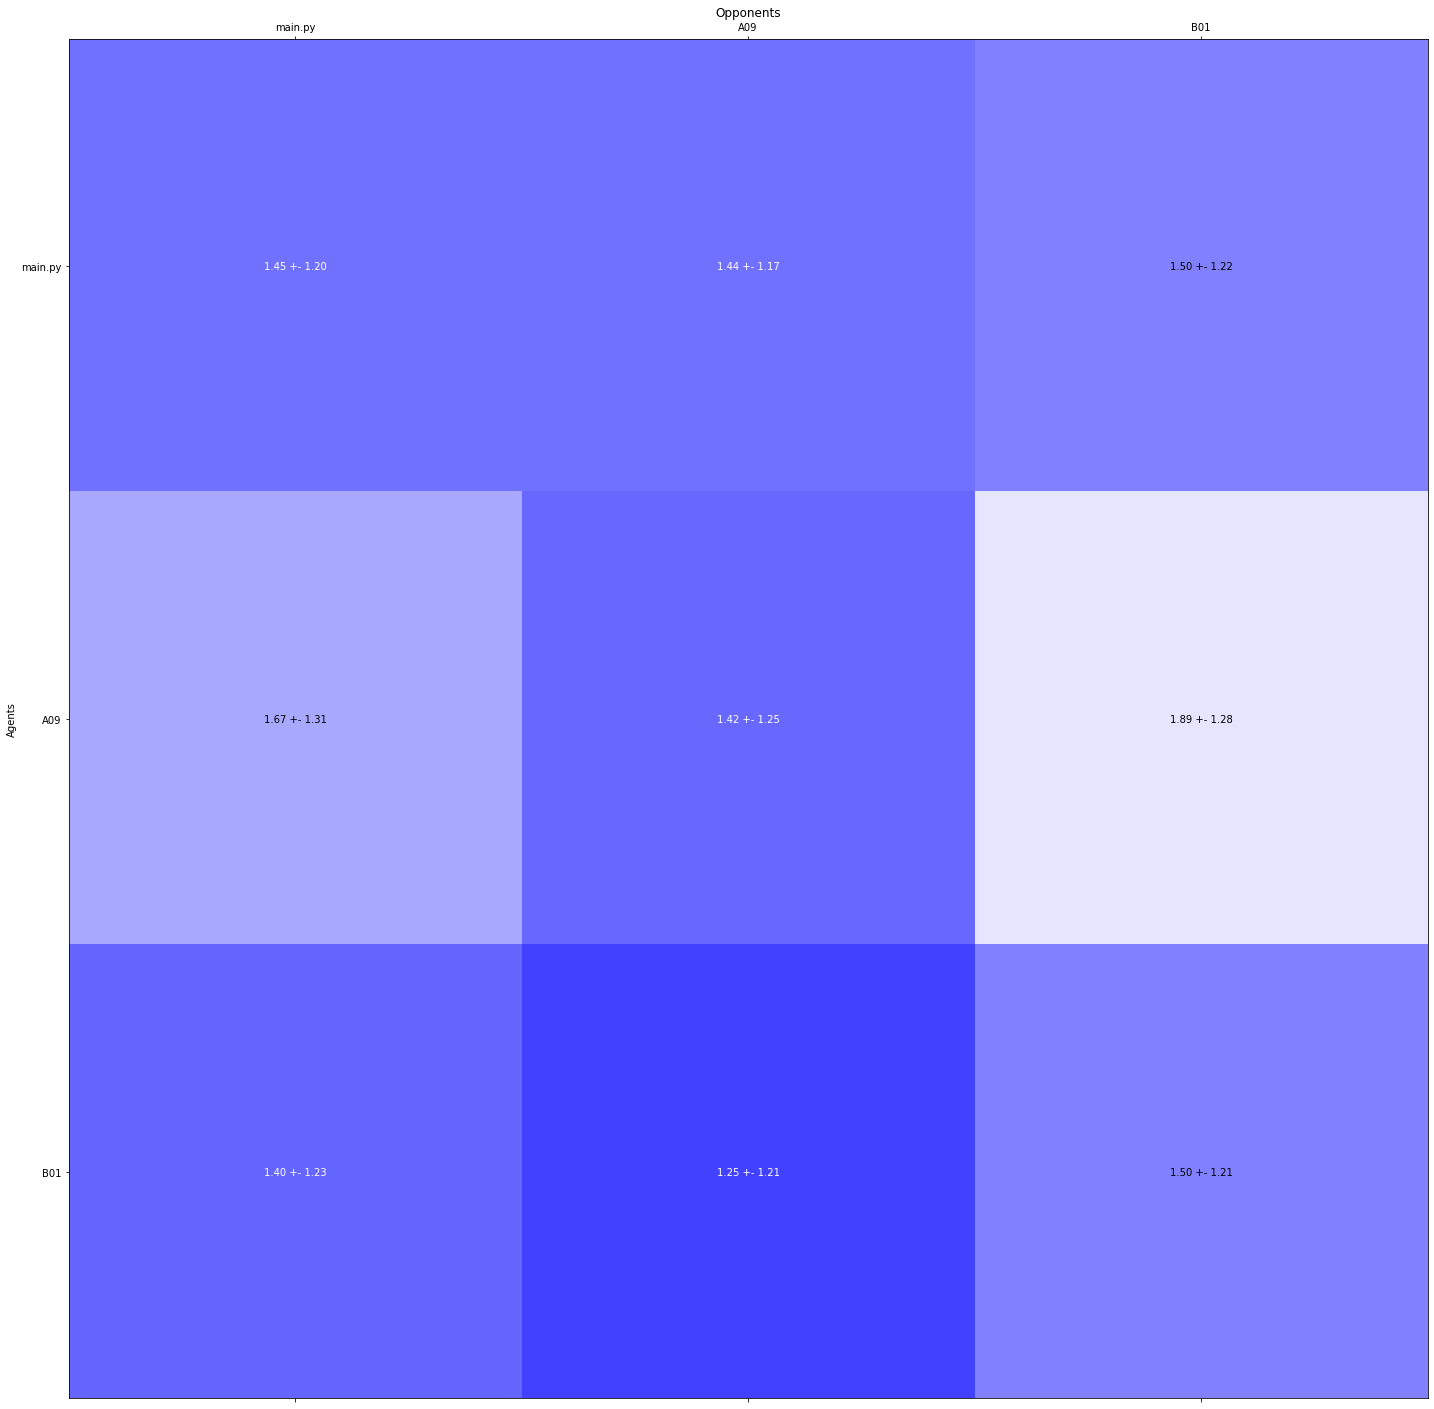

In [17]:
fig, ax = plt.subplots(figsize=(25, 25))
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(point_estimate, cmap='seismic', vmin=0, vmax=4)

ax.set_title("Opponents")
ax.set_ylabel("Agents")

for (i, j), z in np.ndenumerate(point_estimate):
    ax.text(j, i, f"{point_estimate[i][j]:.2f} +- {1.96 * std_dev[i][j]:.2f}", color="black" if abs(point_estimate[i][j] - 2) < 0.5 else "white", ha='center', va='center')

ax.set_xticks(range(len(point_estimate)))
ax.set_yticks(range(len(point_estimate)))
ax.set_xticklabels(tournament_labels)
ax.set_yticklabels(tournament_labels)

plt.show()


In [12]:
single_agent = "main.py"
# opponents = tournament_agents
opponents = ["greedy", "tournament/A09/main.py", "tournament/B01/main.py"]
labels = ["greedy", "A09", "B01"]
single_point_estimate, single_std_dev = evaluate_agent_against_ensemble(single_agent, opponents, num_episodes=100)
single_std_dev /= np.sqrt(len(single_std_dev))

0/100.00, main.py vs greedy

<ipython-input-13-c883e5e04b40>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([single_agent])


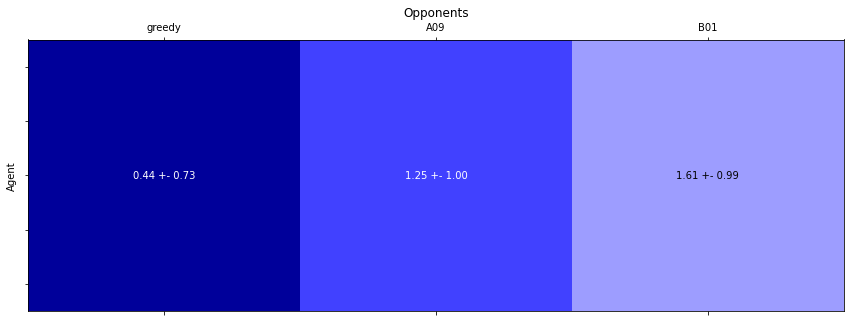

In [13]:
fig, ax = plt.subplots(figsize=(25, 5))
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow([single_point_estimate], cmap='seismic', vmin=0, vmax=4)

ax.set_title("Opponents")
ax.set_ylabel("Agent")

for (i, j), z in np.ndenumerate([single_point_estimate]):
    ax.text(j, i, f"{single_point_estimate[j]:.2f} +- {1.645 * single_std_dev[j]:.2f}", color="black" if abs(single_point_estimate[j] - 2) < 0.5 else "white", ha='center', va='center')

ax.set_xticks(range(len(single_point_estimate)))
ax.set_xticklabels(labels)
ax.set_yticklabels([single_agent])

plt.show()


In [8]:
import main

main.agent

import better_random
better_random.agent(None, None)

'EAST'

In [3]:
from kaggle_environments import make
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
import numpy as np
from shared.memory_manager import MemoryManager

for i in range(1000):
    states = env.run(["greedy", "greedy", "greedy", "greedy"])

    place = MemoryManager.get_place([x[0]["observation"] for x in states])[0]
    for j in range(4):
        if places[j] == -1: 
            print(places)
            print(obs)
    


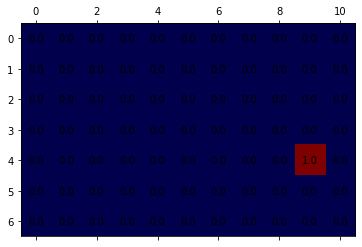

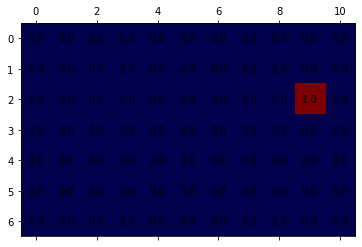

2

In [17]:
import matplotlib.pyplot as plt
import numpy as np

from DQN.model import Model
from shared.memory_manager import MemoryManager
from kaggle_environments.envs.hungry_geese.hungry_geese import Configuration
from kaggle_environments.envs.hungry_geese.hungry_geese import row_col

from shared.map import Map

model = Model()
model.set_config(Configuration({"columns": 11, "rows": 7}))

memory_manager = MemoryManager(-1, 0.99)
memory_manager.add_memory([obs[-3], 1, 1, 3, 0, obs[-2]], 1, 1)


trans_obs = memory_manager.last_episode[0][0]
map = Map(trans_obs, 11)
data = map.build_opponent_map(1)[1].reshape(7,11)
#data = map.build_opponent_map(0)[1].reshape(7,11)

fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(data, cmap='seismic')

for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plt.show()

map = Map(trans_obs, 11, flipped_left_right=False, flipped_up_down=True)
data = map.build_opponent_map(1)[1].reshape(7,11)
#data = map.build_opponent_map(0)[1].reshape(7,11)

fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(data, cmap='seismic')

for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

plt.show()

map.transform_move_wrt_flipping(0)